<a href="https://colab.research.google.com/github/vatsalsaglani/DL-for-coders-part1-2019/blob/master/FASTAI_DATABLOCK_API_DOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Examples of Use</h1></center>

In ```vision.data``` we create an easy ```DataBunch``` suitable for classification by typing:

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip = False)
data = ImageDataBunch.from_folder(path, ds_tfms = tfms, size = 24)

The data here is structured in _ImageNet_ image folder structure style. Here there are two directories _train_ and _valid_ and both contains folders with classes containing data from that class only. With the data block API the similar can be achieved.

In [3]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip = True)
path.ls()

[PosixPath('/root/.fastai/data/mnist_tiny/models'),
 PosixPath('/root/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_tiny/valid'),
 PosixPath('/root/.fastai/data/mnist_tiny/test'),
 PosixPath('/root/.fastai/data/mnist_tiny/train')]

In [5]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/root/.fastai/data/mnist_tiny/train/7')]

In [0]:
data = (ImageItemList.from_folder(path)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats))

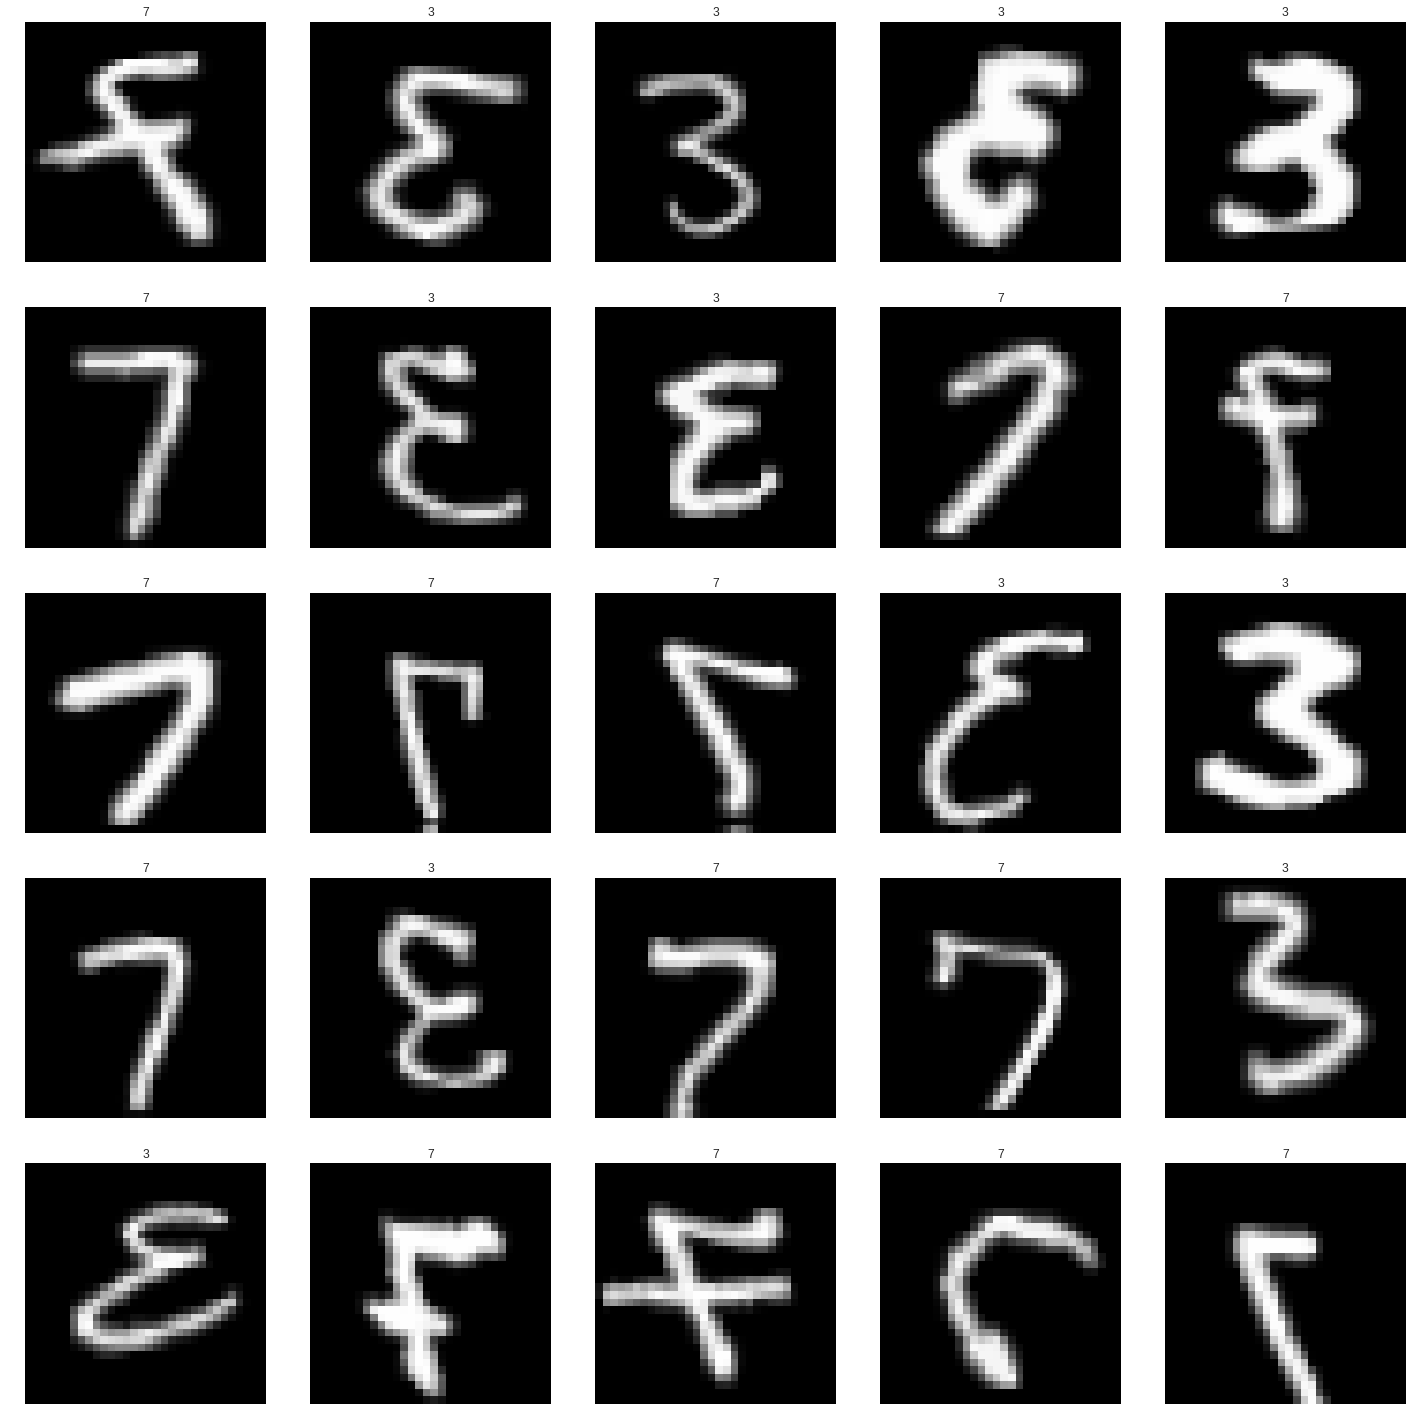

In [8]:
data.show_batch()

In [9]:
data.train_ds[0]

(Image (3, 32, 32), Category 3)

In [10]:
len(data.train_ds)

709

Next we will look at the **planet** dataset, the labels of this images are present inside the _csv_ file and there isn't any _split_ between **valid** and **train** data. 

In [0]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

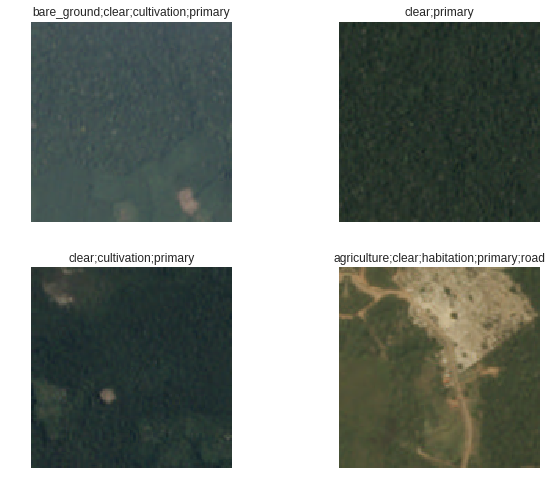

In [13]:
data.show_batch(rows=2, figsize=(9,7))

The data block API allows us to use dataset types for which there is no direct _```ImageDataBunch```_ factory method. For a segmentation task, for instance, we can use it to quickly to get _```DataBunch```_. In the next example the images are inside an _images_ folder and their corresponding mask inside the _labels_ folder

In [0]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road ...)

In [15]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We define a **_lambda_** function that infers the mask filename from the image filename

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Now we easily define a _```DataBunch```_ using the data block API. Here we are applying the transformation _```tfms_y = True```_ in the transform call because we need the transforms applied to be same for both the **train** and **valid** sets. 

In [0]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

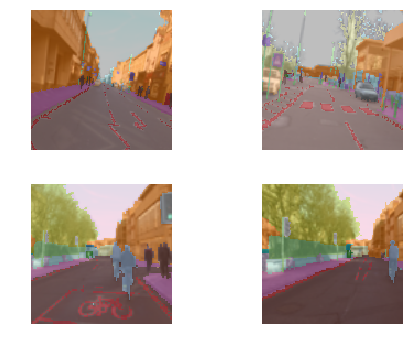

In [18]:
data.show_batch(rows=2, figsize=(7,5))

Object detection example. We use a tiny sampel of the **COCO dataset**. There is a helper function inside the library that _reads the annotation file_ and returns the list of images names with the list of labelled b boxes associated with it. We convert it to a _dictionary_ that maps image names with their bboxes and then write the function that give us the target for each image filename.

In [0]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

Here we are using a simple function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes,  so we need to pad them to the largest number of bounding boxes.

In [0]:
# data = (ImageItemList
#         .from_folder(coco)
#         .random_split_by_pct()
#         .label_from_func(get_y_func)
#         .datasets(ObjectDetectDataset)
#         .databunch(bs=16, collate_fb = bb_pad_collate))
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate


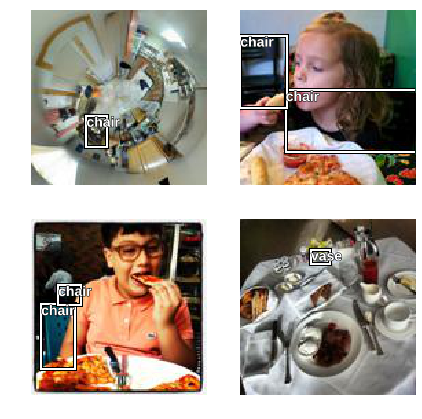

In [27]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))